## **Extracting frames from the video and cropping it and converting it into grey scale**

In [8]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt


def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    for i in range(frame_count):
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()
    return frames



def crop_frames(frames, x, y, width, height):
    cropped_frames = []

    for frame in frames:
        cropped_frame = frame[y:y+height, x:x+width]
        cropped_frames.append(cropped_frame)

    return cropped_frames

def convert_to_bw(frames):
    bw_frames = []

    for frame in frames:
        bw_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        bw_frames.append(bw_frame)

    return bw_frames

# Specify the path to the video file
video_path = '/content/video.mp4'

# Specify the cropping dimensions
x = 70  # x-coordinate of the top-left corner of the crop
y = 90  # y-coordinate of the top-left corner of the crop
width = 1140  # width of the crop
height = 450  # height of the crop


# Extract frames from the video
frames = extract_frames(video_path)

# Crop the frames
cropped_frames = crop_frames(frames, x, y, width, height)

# Convert the cropped frames to black and white
bw_frames = convert_to_bw(cropped_frames)

print("frames cropped and extracted ans stored in bw_frames")

frames cropped and extracted ans stored in bw_frames


### **Finding the pixel intensities of hole in the video**

Maximum pixel intensity in the hole :
98


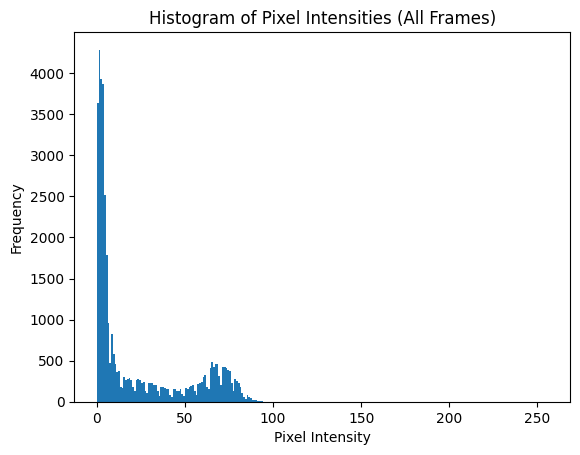

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# Define the region of interest (rectangle coordinates)
roi_x = 433  # X-coordinate of the top-left corner of the rectangle
roi_y = 264  # Y-coordinate of the top-left corner of the rectangle
roi_width = 8  # Width of the rectangle
roi_height = 8  # Height of the rectangle

pixel_values = []

# Process each frame of the video

for frame in bw_frames:
    # Extract the region of interest
    roi = frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]

    # Convert the region of interest to grayscale
    #gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Accumulate pixel values
    pixel_values.extend(roi.flatten())



# Calculate the histogram of pixel intensities using NumPy
histogram, bin_edges = np.histogram(pixel_values, bins=256, range=[0, 256])
print("Maximum pixel intensity in the hole :")
print(max(pixel_values))
# Plot the histogram
plt.hist(pixel_values,bin_edges )
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Intensities (All Frames)')
plt.show()


# Finding Midpoints of the ball in each frame

In [ ]:
def find_ball_midpoints(frames):
    midpoint_list = []

    for index, frame in enumerate(frames):

           # Apply a threshold to convert the image to binary (black and white)
           _, binary = cv2.threshold(frame, 100, 255, cv2.THRESH_BINARY)

           y_coords, x_coords = np.nonzero(binary) #getting ball pixels only


           if len(y_coords) > 0:


                # Find the starting pixels in each direction
               top_pixel = (np.min(x_coords), np.min(y_coords))
               bottom_pixel = (np.max(x_coords), np.max(y_coords))

               # Calculate the mid pont  of rectangle  using the starting pixels
               midpoint_x = (top_pixel[0] + bottom_pixel[0]) / 2
               midpoint_y = (top_pixel[1] + bottom_pixel[1]) / 2

               print((index,int(midpoint_x), 450 - int(midpoint_y)))
               midpoint_list.append((index,int(midpoint_x), 450 - int(midpoint_y)))
           else:
               print((index, 0, 0))

    return midpoint_list


midpoints = find_ball_midpoints(bw_frames)


## **From midpoints, seperating frame numbers, x and y co-ordinates. Calculating delta x,delta y, delta y/delta x which is slope**

In [ ]:
# Extract frame_no, x, and y coordinates from the midpoints tuples
frame_nos = [t[0] for t in midpoints]
x_coords = [t[1] for t in midpoints]
y_coords = [t[2] for t in midpoints]

# Calculate delta x
delta_x = np.diff(x_coords)

# Calculate delta y
delta_y = np.diff(y_coords)

# Calculate delta y / delta x which is tan (theta)
delta_ratio = np.divide(delta_y, delta_x)

Plotting frame number versus slope graph